In [1]:
import gc
gc.collect()

0

In [2]:
from __future__ import print_function
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
import sys

sys.path.append("C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project/")

# Import helper functions
from networks import NeuralNetwork
from optimization.optimizers import StochasticGradientDescent, Adam, RMSprop, Adagrad, Adadelta
from networks.loss_functions import CrossEntropy, SquareLoss, MSE
from utils.misc import bar_widgets
from networks.layers import Dense, Dropout, Activation, BatchNormalization, Conv2D, Flatten
from helpers.helper import *
from helpers.processing import *

import pandas as pd
from numpy import save
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler

import time

In [3]:
#-------------------------------------------------------------------------------------------------#

def plot_transformed_to_img(X, index_plot):

    plt.imshow(X[index_plot][0])
    plt.title("Image on channel 1")
    plt.show()

    plt.imshow(X[index_plot][1])
    plt.title("Image on channel 2")
    plt.show()
    
#-------------------------------------------------------------------------------------------------#

def evaluate_ber(y_pred, y_test, index_pred, nsymbols):
    
    nLayers = 500                         # Number of Layers of the Generative network
    y_ori = y_test[index_pred]
    # Initialize parameters
    parameters = Parameters(nsymbols=nsymbols, nLayers=nLayers)
    # Initialize the Equalizer
    equalizer = Equalizer()
    # Initialize the Demodulator
    demodulator = Demodulator()
    # Initialize the Transmitor
    transmitor = Transmitor()
    # Initialize the Detector
    detector = Detector(transmitor)
    
    # propagation & equalization.
    q0t = fromRealToComplex(y_pred)    
    #qzt, qzf = channel.channel(parameters.t, q0t, parameters.z, parameters.sigma2, parameters.B) 
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    #shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)
    shat = demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    bhat = detector.symbols_to_bit(indexes, parameters.M)
    y_ori = y_ori.reshape(1,-1)
    # propagation & equalization.
    q0t = fromRealToComplex(y_ori)
    print(q0t.shape)
    qzt = q0t
    qzte, qzfe = equalizer.equalize(parameters.t, qzt, parameters.z) # equalized output
    # demodulation
    shat = demodulator.demod(parameters.t, parameters.dt, qzte, parameters.B, parameters.n)

    # detection
    stilde, indexes = detector.detector(shat, parameters.M)
    b = detector.symbols_to_bit(indexes, parameters.M)
    
    ser = detector.ser(s, stilde)  # symbol error rate
    ber = detector.ber(b, bhat)  # bit error rate
    
    print("b : ", b)
    print("bhat : ", bhat)
    print("ber : ", ber)
    print("ser : ", ser)    
    
#-------------------------------------------------------------------------------------------------#
    
def evals(model, X_test, y_test, index_pred, opti, train_err, val_err, nsymbols=16):
    
    # Reshape images to go back to Signal
    x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
    #x_test_original = X_test.reshape(X_test.shape[0], 2048,1)
    
    # Training and validation error plot
    n = len(train_err)
    training, = plt.plot(range(n), train_err, label="Training Error")
    validation, = plt.plot(range(n), val_err, label="Validation Error")
    plt.legend(handles=[training, validation])
    plt.title("Error Plot using "+str(opti))
    plt.ylabel('Error')
    plt.xlabel('Iterations')
    plt.show()
    
    y_pred = model.predict(x_tester[index_pred])
    
    plt.title("Predicted Signal")
    plt.plot(np.squeeze(np.abs(y_pred)))
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    plt.title("Predicted Signal vs Original")
    plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
    plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
    plt.legend()
    plt.show()
    
    evaluate_ber(y_pred, y_test, index_pred, nsymbols)
    
    return y_pred

#-------------------------------------------------------------------------------------------------#

def get_prepared_mod_data(ts= 0.25, withReshape = True):
    
    d80K = np.load('../data/modulation/80K_XY_16_symb.npz')
    
    X = d80K['X'] # distorted source
    y = d80K['y'] # original source
    
    t1 = time.time()
    df = prepareDataFrame(X, y)
    t2 = time.time()
    
    print("[INFO] Total time to prepare the dataframe is : ", t2-t1, " seconds.")

    X_train, X_test, y_train, y_test = prepareTrainAndTestData(df, withReshape, ts)
    
    print("[INFO] Reshaping datas...")
    
    # Reshape X to (n_samples, channels, height, width) (2*32*32 = 2048)
    X_train = X_train.reshape((X_train.shape[0],2,32,32))
    X_test = X_test.reshape((X_test.shape[0],2,32,32))
    y_train = np.squeeze(y_train)
    y_test = np.squeeze(y_test)
    
    print("X_train.shape : ",X_train.shape)
    print("y_train.shape : ",y_train.shape)
    print("X_test.shape : ",X_test.shape)
    print("y_test.shape : ",y_test.shape)
    
    return X_train, X_test, y_train, y_test

#-------------------------------------------------------------------------------------------------#

In [4]:
X_train, X_test, y_train, y_test = get_prepared_mod_data()

  0%|                                                                              | 79/80000 [00:00<01:41, 788.45it/s]


 [INFO] {fromComplexToReal} runing...


  0%|                                                                              | 98/80000 [00:00<01:22, 971.77it/s]

 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)

 [INFO] {fromComplexToReal} runing...


100%|███████████████████████████████████████████████████████████████████████████| 80000/80000 [01:36<00:00, 833.00it/s]


 [INFO] {fromComplexToReal} vect_real.shape :  (80000, 2048)
{prepareDataFrame} df_.shape :  (80000, 4096)
[INFO] Total time to prepare the dataframe is :  206.83215427398682  seconds.
[INFO] - {prepareTrainAndTestData} converting from pandas to numpy...
[INFO] train and test data are ready.
X.shape :  (80000, 2048)
y.shape :  (80000, 2048)
X_train.shape :  (60000, 2048, 1)
y_train.shape :  (60000, 2048, 1)
X_test.shape :  (20000, 2048, 1)
y_test.shape :  (20000, 2048, 1)
[INFO] Reshaping datas...
X_train.shape :  (60000, 2, 32, 32)
y_train.shape :  (60000, 2048)
X_test.shape :  (20000, 2, 32, 32)
y_test.shape :  (20000, 2048)


In [5]:
print("X_train.shape : ",X_train.shape)
print("y_train.shape : ",y_train.shape)
print("X_test.shape : ",X_test.shape)
print("y_test.shape : ",y_test.shape)

X_train.shape :  (60000, 2, 32, 32)
y_train.shape :  (60000, 2048)
X_test.shape :  (20000, 2, 32, 32)
y_test.shape :  (20000, 2048)


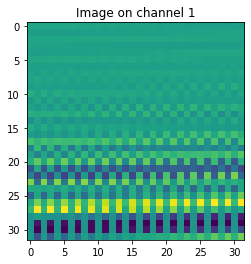

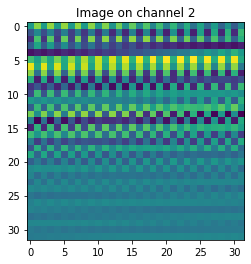

In [8]:
index_plot = 689
plot_transformed_to_img(X_train, index_plot)

In [6]:
x_tr = X_train[0:1000,:,:]
x_te = X_test[1100:1500,:,:]
y_tr = y_train[0:1000,:]
y_te = y_test[1100:1500,:]

In [7]:
# Reshape X to (n_samples, channels, height, width) (2*32*32 = 2048)
x_tr = x_tr.reshape((x_tr.shape[0],2,32,32))
x_te = x_te.reshape((x_te.shape[0],2,32,32))
y_tr = np.squeeze(y_tr)
y_te = np.squeeze(y_te)

## Models

In [9]:
optimizer = Adam()
opti = 'Adam'
n_features = 2048
n_output = 2048
ccn_1 = NeuralNetwork(optimizer=optimizer,
                        loss=SquareLoss,
                        validation_data=(X_test, y_test))

In [10]:
ccn_1.add(Conv2D(n_filters=64, filter_shape=(3,3), stride=1, input_shape=(2,32,32), padding='same'))
ccn_1.add(Activation('elu'))

ccn_1.add(Conv2D(n_filters=32, filter_shape=(3,3), stride=1, padding='same'))
ccn_1.add(Activation('elu'))

ccn_1.add(Flatten())

ccn_1.add(Dense(64))
ccn_1.add(Activation('elu'))

ccn_1.add(Dense(16))
ccn_1.add(Activation('elu'))

ccn_1.add(Dense(64))
ccn_1.add(Activation('elu'))

ccn_1.add(Dense(n_output))
ccn_1.add(Activation('elu'))

print ()
ccn_1.summary(name="Conv2D")


+--------+
| Conv2D |
+--------+
Input Shape: (2, 32, 32)
+------------------+------------+--------------+
| Layer Type       | Parameters | Output Shape |
+------------------+------------+--------------+
| Conv2D           | 1216       | (64, 32, 32) |
| Activation (ELU) | 0          | (64, 32, 32) |
| Conv2D           | 18464      | (32, 32, 32) |
| Activation (ELU) | 0          | (32, 32, 32) |
| Flatten          | 0          | (32768,)     |
| Dense            | 2097216    | (64,)        |
| Activation (ELU) | 0          | (64,)        |
| Dense            | 1040       | (16,)        |
| Activation (ELU) | 0          | (16,)        |
| Dense            | 1088       | (64,)        |
| Activation (ELU) | 0          | (64,)        |
| Dense            | 133120     | (2048,)      |
| Activation (ELU) | 0          | (2048,)      |
+------------------+------------+--------------+
Total Parameters: 2252144



### Train Conv2D simple

I had some hardware limitation (Memory issues) running it on a bigger dataset, therefore, in this experience we just showcase the performance we can get with a simple convolutional network in this problem.

In [15]:
num_epochs = 40
batch_size = 32

In [29]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  32
[INFO] Training epochs number :  40


C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\activation_functions.py:82: RuntimeWarning: overflow encountered in exp
  return x*np.exp(2*dz*abs2)
C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\activation_functions.py:82: RuntimeWarning: overflow encountered in multiply
  return x*np.exp(2*dz*abs2)
C:/Users/admin/Desktop/IP Paris/MICAS/Cours/910/913 - Deep Learning/Project\networks\loss_functions.py:24: RuntimeWarning: overflow encountered in power
  return 0.5 * np.power((y - y_pred), 2)


[INFO] Training loss on epoch  1  :  0.44021
[INFO] Validation loss on epoch  1  :  inf
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.39179
[INFO] Validation loss on epoch  2  :  inf
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.37122
[INFO] Validation loss on epoch  3  :  2981257357755.51953
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.35991
[INFO] Validation loss on epoch  4  :  0.46527
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.35237
[INFO] Validation loss on epoch  5  :  0.31231
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.34714
[INFO] Validation loss on epoch  6  :  0.31238
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.34266
[INFO] Validation loss on epoch  7  :  0.31257
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.33925
[INFO] Validation loss on epoch  8  :  0.31246
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.33638
[INFO] Validation loss on epoch  9  :  0.31321
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.33372
[INFO] Validation loss on epoch  10  :  0.32189
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  11  :  0.33187
[INFO] Validation loss on epoch  11  :  0.35744
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  12  :  0.32987
[INFO] Validation loss on epoch  12  :  5.26510
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  13  :  0.32838
[INFO] Validation loss on epoch  13  :  2597670770808041.50000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  14  :  0.32689
[INFO] Validation loss on epoch  14  :  174862318266368889060819836877903121415076975475985350688226335126090215294077256236347144921218547712.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  15  :  0.32543
[INFO] Validation loss on epoch  15  :  6637224512111798580219627858296793423966536458916990242693561910503602412085667759684120571762125992364009915196630759031660248825856.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  16  :  0.32421
[INFO] Validation loss on epoch  16  :  2775201705150315842693320053042264658220311241662761735069727822529062491859076513792.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  17  :  0.32341
[INFO] Validation loss on epoch  17  :  2986682014676153190460978151859606222468622057472.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  18  :  0.32181
[INFO] Validation loss on epoch  18  :  146895203855889200054272.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  19  :  0.32103
[INFO] Validation loss on epoch  19  :  30386254240947895163136869839296630506862386448294691227815750968431049192467001593580029476864.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  20  :  0.32022
[INFO] Validation loss on epoch  20  :  65282818028249.35156
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  21  :  0.31945
[INFO] Validation loss on epoch  21  :  185457392079.32410
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  22  :  0.31860
[INFO] Validation loss on epoch  22  :  536780558057458176.00000
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  23  :  0.31777
[INFO] Validation loss on epoch  23  :  496160961899.26202
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  24  :  0.31728
[INFO] Validation loss on epoch  24  :  3938602497.26172
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  25  :  0.31647
[INFO] Validation loss on epoch  25  :  0.58353
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  26  :  0.31616
[INFO] Validation loss on epoch  26  :  0.33207
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  27  :  0.31541
[INFO] Validation loss on epoch  27  :  0.32376
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  28  :  0.31495
[INFO] Validation loss on epoch  28  :  0.32877
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  29  :  0.31467
[INFO] Validation loss on epoch  29  :  0.31683
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  30  :  0.31411
[INFO] Validation loss on epoch  30  :  0.32376
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  31  :  0.31358
[INFO] Validation loss on epoch  31  :  0.31328
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  32  :  0.31304
[INFO] Validation loss on epoch  32  :  0.31382
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  33  :  0.31263
[INFO] Validation loss on epoch  33  :  0.31353
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  34  :  0.31247
[INFO] Validation loss on epoch  34  :  0.31284
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  35  :  0.31171
[INFO] Validation loss on epoch  35  :  0.31252
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  36  :  0.31165
[INFO] Validation loss on epoch  36  :  0.31251
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  37  :  0.31112
[INFO] Validation loss on epoch  37  :  0.31267
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  38  :  0.31047
[INFO] Validation loss on epoch  38  :  0.31243
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  39  :  0.31012
[INFO] Validation loss on epoch  39  :  0.31252
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  40  :  0.30993
[INFO] Validation loss on epoch  40  :  0.31258
-------------------------------------------------------------------------------


### Evaluation

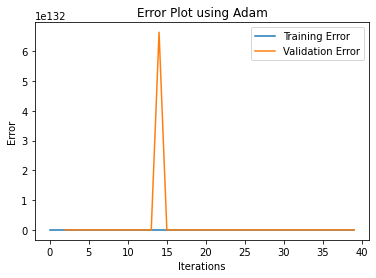

In [30]:
# Training and validation error plot
n = len(train_err)
training, = plt.plot(range(n), train_err, label="Training Error")
validation, = plt.plot(range(n), val_err, label="Validation Error")
plt.legend(handles=[training, validation])
plt.title("Error Plot using "+str(opti))
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

In [31]:
x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

[[ 1.64886659e-04 -2.85909354e-04 -1.71548704e-04 ... -7.70864308e-04
   4.32076692e-04 -2.94914018e-05]]


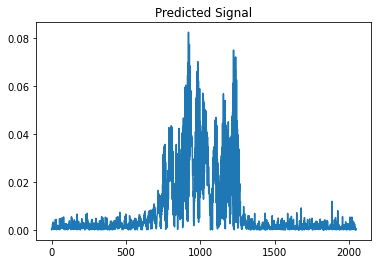

In [32]:
index_pred = 54
y_pred = clf.predict(x_tester[index_pred])
print(y_pred)
plt.title("Predicted Signal")
plt.plot(np.squeeze(np.abs(y_pred)))
plt.show()

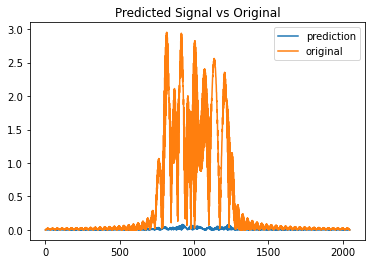

In [33]:
plt.title("Predicted Signal vs Original")
plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
plt.legend()
plt.show()

### Train Con2D simple

In [27]:
num_epochs = 10
batch_size = 32

In [28]:
print("[INFO] Batch size : ", batch_size)
print("[INFO] Training epochs number : ", num_epochs)
train_err, val_err = clf.fit(X_train, y_train, num_epochs, batch_size=batch_size)

[INFO] Batch size :  32
[INFO] Training epochs number :  10


[INFO] Training loss on epoch  1  :  0.46162
[INFO] Validation loss on epoch  1  :  0.62825
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  2  :  0.38110
[INFO] Validation loss on epoch  2  :  0.36889
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  3  :  0.35000
[INFO] Validation loss on epoch  3  :  0.32711
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  4  :  0.33816
[INFO] Validation loss on epoch  4  :  0.31680
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  5  :  0.33085
[INFO] Validation loss on epoch  5  :  0.31323
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  6  :  0.32529
[INFO] Validation loss on epoch  6  :  0.31138
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  7  :  0.32103
[INFO] Validation loss on epoch  7  :  0.31039
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  8  :  0.31825
[INFO] Validation loss on epoch  8  :  0.30951
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  9  :  0.31598
[INFO] Validation loss on epoch  9  :  0.30862
-------------------------------------------------------------------------------


[INFO] Training loss on epoch  10  :  0.31362
[INFO] Validation loss on epoch  10  :  0.30755
-------------------------------------------------------------------------------


### Evaluation

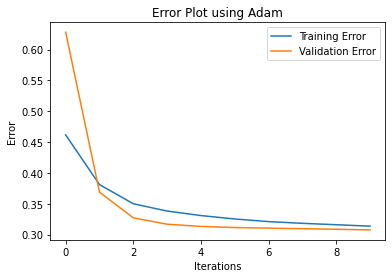

In [31]:
# Training and validation error plot
n = len(train_err)
training, = plt.plot(range(n), train_err, label="Training Error")
validation, = plt.plot(range(n), val_err, label="Validation Error")
plt.legend(handles=[training, validation])
plt.title("Error Plot using "+str(opti))
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

In [32]:
_, loss = clf.test_on_batch(X_test, y_test)
print ("Test loss:", loss)

Test loss: 0


In [34]:
x_tester = X_test.reshape(X_test.shape[0], -1, 2,32,32)
x_test_original = X_test.reshape(X_test.shape[0], 2048,1)

In [35]:
index_pred = 54

[[0.04409289 0.00688274 0.04464493 ... 0.06249855 0.03349153 0.05991256]]


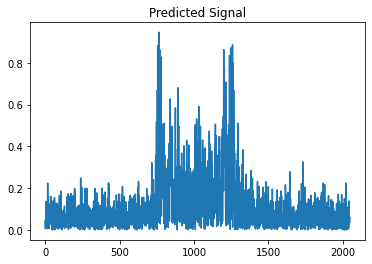

In [36]:
y_pred = clf.predict(x_tester[index_pred])
print(y_pred)
plt.title("Predicted Signal")
plt.plot(np.squeeze(np.abs(y_pred)))
plt.show()

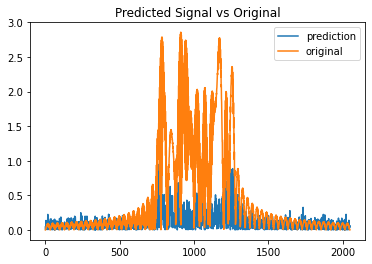

In [37]:
plt.title("Predicted Signal vs Original")
plt.plot(np.squeeze(np.abs(y_pred)), label="prediction")
plt.plot(np.squeeze(np.abs(y_test[index_pred])), label="original")
plt.legend()
plt.show()

In [38]:
print ("max val :", np.max(y_pred))
print ("shape  :", y_pred.shape)

max val : 0.9467448413274234
shape  : (1, 2048)
